Number of communities detected: 23
Community detection results saved to 'community_detection_output_leiden.csv'

Community-wise node counts:
Community 0: 219 nodes
Community 1: 119 nodes
Community 2: 85 nodes
Community 3: 67 nodes
Community 4: 63 nodes
Community 5: 52 nodes
Community 6: 51 nodes
Community 7: 25 nodes
Community 8: 22 nodes
Community 9: 18 nodes
Community 10: 18 nodes
Community 11: 14 nodes
Community 12: 8 nodes
Community 13: 8 nodes
Community 14: 8 nodes
Community 15: 6 nodes
Community 16: 5 nodes
Community 17: 5 nodes
Community 18: 5 nodes
Community 19: 4 nodes
Community 20: 3 nodes
Community 21: 3 nodes
Community 22: 3 nodes


C:\Users\bshar\AppData\Local\Temp\ipykernel_16256\929260486.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(unique_communities))  # Use a rainbow colormap


Community detection plot saved to 'community_detection_bipartite_leiden.png'


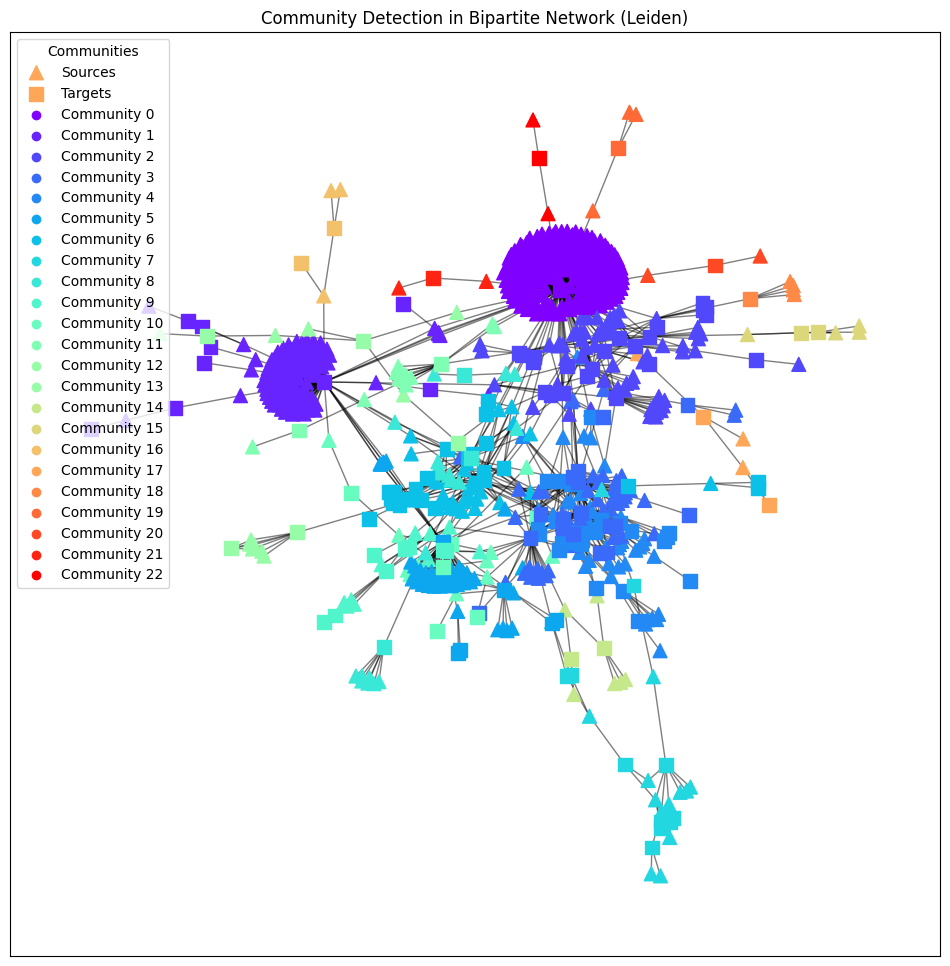


Nodes grouped by communities:
Community 0: ['GNB2 ', 'GLYR1 ', 'GOLGA2 ', 'GON4L ', 'GIN1 ', 'GFAP ', 'HIVEP2 ', 'HOXD8 ', 'GBP2 ', 'HSFX2 ']
Community 1: ['HAX1 ', 'HNRNPK ', 'KHDRBS1 ', 'SF3B2 ', 'MAGED1 ', 'HNRNPA2B1 ', 'HSPA8 ', 'SET ', 'AKAP8L ', 'ALDH1B1 ']
Community 2: ['PSMA3 ', 'TRAF2 ', 'IKBKG ', 'GRN ', 'ACTN1 ', 'LMNB1 ', 'SLIT2 ', 'PSME3 ', 'RNF31 ', 'MMRN2 ']
Community 3: ['CDK1 ', 'MAP2K7 ', 'MAPK8IP1 ', 'JUN ', 'PURA ', 'RBL2 ', 'RBL1 ', 'RB1 ', 'HDAC1 ', 'CCNA2 ']
Community 4: ['EP300 ', 'KAT2B ', 'SMN1 ', 'BRD4 ', 'POMP ', 'CITED1 ', 'GTF2B ', 'TBP ', 'CEBPB ', 'CEBPA ']
Community 5: ['RUVBL1 ', 'SYNCRIP ', 'XRCC5 ', 'SF3B1 ', 'RAD50 ', 'CCNT1 ', 'KAT5 ', 'SUB1 ', 'SMARCA2 ', 'CDK9 ']
Community 6: ['RCN2 ', 'TP73 ', 'TP53 ', 'GPS2 ', 'BAK1 ', 'PTPN3 ', 'UBE3A ', 'MAGI1 ', 'DLG1 ', 'FBLN1 ']
Community 7: ['BTRC ', 'NCKIPSD ', 'RAF1 ', 'HCK ', 'MAP3K5 ', 'AP1B1 ', 'LYN ', 'SRC ', 'FYN ', 'FKBP5 ']
Community 8: ['SRSF1 ', 'USP7 ', 'SH3KBP1 ', 'HDAC3 ', 'HDAC4 ', 'HDAC7 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import community as community_louvain
import leidenalg
import igraph as ig

# Path to your CSV file
file_path = 'bipartite_host_viral.csv'  # Replace with your actual file path

# Load data
bipartite_data = pd.read_csv(file_path)

# Ensure the CSV has 'source' and 'target' columns
sources = bipartite_data['source']
targets = bipartite_data['target']

# Create a bipartite graph
B = nx.Graph()
B.add_nodes_from(sources, bipartite=0)  # Add source nodes (type 0)
B.add_nodes_from(targets, bipartite=1)  # Add target nodes (type 1)
B.add_edges_from(zip(sources, targets))  # Add edges between sources and targets

# Check if the graph is bipartite
if not bipartite.is_bipartite(B):
    raise ValueError("The graph is not bipartite!")

# Function for Louvain community detection
def louvain_community_detection(graph):
    partition = community_louvain.best_partition(graph, resolution=1.0)
    return partition

# Function for Leiden community detection
def leiden_community_detection(graph):
    ig_graph = ig.Graph.from_networkx(graph)
    partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)
    return {node: membership for node, membership in zip(graph.nodes(), partition.membership)}

# Choose the algorithm ('louvain' or 'leiden')
algorithm = 'leiden'  # Replace with 'leiden' if needed

if algorithm == 'louvain':
    partition = louvain_community_detection(B)
    output_file = 'community_detection_output_louvain.csv'
    plot_file = 'community_detection_bipartite_louvain.png'
elif algorithm == 'leiden':
    partition = leiden_community_detection(B)
    output_file = 'community_detection_output_leiden.csv'
    plot_file = 'community_detection_bipartite_leiden.png'
else:
    raise ValueError("Invalid algorithm choice. Use 'louvain' or 'leiden'.")

# Extract number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Add community labels to the graph
nx.set_node_attributes(B, partition, 'community')

# Group nodes by community and count nodes in each community
community_groups = {community_id: [] for community_id in set(partition.values())}
for node, community in partition.items():
    community_groups[community].append(node)

# Prepare the data for CSV output, including node counts
community_data = []
for community_id, nodes in community_groups.items():
    community_str = ', '.join(nodes)  # Join node names by commas
    community_data.append({
        'Community': f'Community {community_id}',
        'Node Count': len(nodes),  # Number of nodes in the community
        'Nodes': community_str
    })

# Create a DataFrame for the CSV output
community_df = pd.DataFrame(community_data)

# Save to CSV file
community_df.to_csv(output_file, index=False)
print(f"Community detection results saved to '{output_file}'")

# Print community-wise node counts in the console
print("\nCommunity-wise node counts:")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

# Visualize the communities
plt.figure(figsize=(12, 12))
plt.title(f"Community Detection in Bipartite Network ({algorithm.capitalize()})")

# Assign colors to nodes based on their community
unique_communities = set(partition.values())
cmap = plt.cm.get_cmap('rainbow', len(unique_communities))  # Use a rainbow colormap

# Use a spring layout for visualization
pos = nx.spring_layout(B)

# Draw source nodes (type 0) as triangles
source_nodes = [node for node in B.nodes if B.nodes[node]['bipartite'] == 0]
nx.draw_networkx_nodes(
    B, pos,
    nodelist=source_nodes,
    node_color=[cmap(partition[node] / len(unique_communities)) for node in source_nodes],
    node_size=100,
    node_shape='^',  # Triangle
    label="Sources"
)

# Draw target nodes (type 1) as squares
target_nodes = [node for node in B.nodes if B.nodes[node]['bipartite'] == 1]
nx.draw_networkx_nodes(
    B, pos,
    nodelist=target_nodes,
    node_color=[cmap(partition[node] / len(unique_communities)) for node in target_nodes],
    node_size=100,
    node_shape='s',  # Square
    label="Targets"
)

# Draw edges
nx.draw_networkx_edges(B, pos, alpha=0.5)

# Add legend for communities
for community_id in unique_communities:
    plt.scatter([], [], color=cmap(community_id / len(unique_communities)), label=f"Community {community_id}")
plt.legend(scatterpoints=1, loc='upper left', title="Communities")

# Save the output image
plt.savefig(plot_file, format='PNG')
print(f"Community detection plot saved to '{plot_file}'")

# Display the plot
plt.show()

# Print example nodes in each community
print("\nNodes grouped by communities:")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {nodes[:10]}")  # Display first 10 nodes for brevity
